## Calculate surface-forced watermass transformation
Presently, information about the products, e.g. names of variables is hard-coded. Could improve robustness by specifying generic names.

In [6]:
%load_ext autoreload
%autoreload 2
from dask.diagnostics import ProgressBar
import so_decadal_variability as so
import numpy as np
import xarray as xr
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
fluxname='era5'
oceanname='en4'
onoceangrid=False
density = 'gamman'
timeslice = slice('1980','2018')
dg = 0.1
density_edges = np.arange(1026,1028.5,dg)
save = False
ds = so.process.loaddata(fluxname,oceanname,timeslice,onoceangrid)
# ds, xgrid = so.grid.get_xgcm(ds)

KeyError: 'lon'

In [24]:
ds

<xarray.Dataset>
Dimensions:     (bnds: 2, depth: 42, latitude: 241, longitude: 1440, time: 468)
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2018-12-01
  * longitude   (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude    (latitude) float32 -30.0 -30.25 -30.5 ... -89.5 -89.75 -90.0
  * depth       (depth) float32 5.022 15.08 25.16 ... 5.051e+03 5.35e+03
Dimensions without coordinates: bnds
Data variables:
    fw          (time, latitude, longitude) float32 dask.array<chunksize=(468, 241, 1440), meta=np.ndarray>
    ht          (time, latitude, longitude) float32 dask.array<chunksize=(468, 241, 1440), meta=np.ndarray>
    sr          (time, latitude, longitude) float32 dask.array<chunksize=(468, 241, 1440), meta=np.ndarray>
    time_bnds   (time, bnds) datetime64[ns] dask.array<chunksize=(468, 2), meta=np.ndarray>
    depth_bnds  (depth, bnds) float32 dask.array<chunksize=(42, 2), meta=np.ndarray>
    sa          (time, depth, latitude, longitude) float32 dask.array<chunksize=(468, 42, 241, 1440), meta=np.ndarray>
    cell_area   (latitude, longitude) float64 dask.array<chunksize=(241, 1440), meta=np.ndarray>
    dx          (latitude, longitude) float32 dask.array<chunksize=(241, 1440), meta=np.ndarray>
    dy          (latitude, longitude) float32 dask.array<chunksize=(241, 1440), meta=np.ndarray>
    mask        (latitude, longitude) float64 dask.array<chunksize=(241, 1440), meta=np.ndarray>

In [2]:
fluxname='era5'
oceanname='en4'
onoceangrid=False
density = 'gamman'
timeslice = slice('1980','2018')
dg = 0.1
density_edges = np.arange(1026,1028.5,dg)
save = False
ds = so.process.loaddata(fluxname,oceanname,timeslice,onoceangrid)
ds, xgrid = so.grid.get_xgcm(ds)

# Hack to get around grid errors in IAP for now
# if oceanname=='iap':
#     ds['vol4d'] = ds['dx']*ds['dy']*ds['dz']*xr.ones_like(ds['vol4d'])

b_cap = True
cap = 9999
if b_cap:
    condition = (ds['b']>cap) & (~np.isnan(ds['b']))
    ds['b'] = ds['b'].where(~condition,cap)
    
G = so.wmt.calc_watermasstransformation(ds,xgrid,density_edges,density=density,b_ones=False)

if save:
    with ProgressBar():
        localdir = '../data/processed/'+fluxname+'_'+oceanname
        if ~os.path.isdir(localdir):
            !mkdir $localdir
        filename = 'G.'+density+'.'+str(dg)
        if (density=='gamman') & b_cap:
            filename = filename+'.b_cap-'+str(cap)
        G.to_netcdf(localdir+'/'+filename+'.nc')

In [3]:
with ProgressBar():
    G.load()

[########################################] | 100% Completed | 47.7s


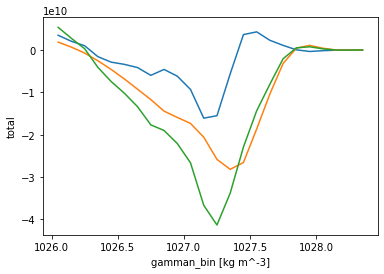

In [4]:
G['heat'].mean('time').plot()
G['fw'].mean('time').plot()
G['total'].mean('time').plot()

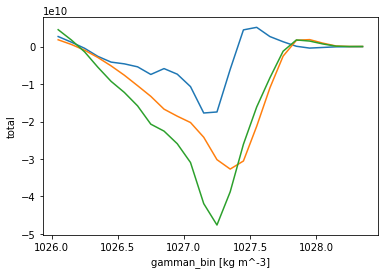

In [103]:
G['heat'].mean('time').plot()
G['fw'].mean('time').plot()
G['total'].mean('time').plot()

In [40]:
G['heat'].sel(time='2002-10-01',gamman_bin=1027.85,method='nearest')

<xarray.DataArray 'heat' ()>
array(5.75621555e+08)
Coordinates:
    time        datetime64[ns] 2002-10-01
    gamman_bin  float64 1.028e+03

In [71]:
dsnow = ds.sel(time=slice('2002-09-01','2002-10-01'))

In [72]:
# from xhistogram.xarray import histogram

bins=np.arange(1026,1028.5,0.1)
F = so.wmt.calc_densityflux(dsnow,xgrid)
gbFV = ds['gamman']*ds['b']*F['heat']*ds['vol4d']
# dsnow['gamman'].sel(depth=0,method='nearest').plot()

In [74]:
condition = (dsnow['gamman']>1027.7)&(dsnow['gamman']<=1027.8)
gbFV.where(condition,0).isel(time=0).sum(xr.ALL_DIMS).values

array(4.2765666e+09)

In [81]:
dsnow['b'].max().values

array(inf)

In [68]:
G['heat']['gamman_bin'].diff('gamman_bin')

<xarray.DataArray 'gamman_bin' (gamman_bin: 23)>
array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
Coordinates:
  * gamman_bin  (gamman_bin) float64 1.026e+03 1.026e+03 ... 1.028e+03 1.028e+03